In [35]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
from datetime import datetime
from scipy.interpolate import LSQUnivariateSpline
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

# read excel file
df = pd.read_excel('C1Data.xlsx', sheet_name=None)

# name the sheets
bonds = df['Bonds']
yield_curve = df['YieldCurve']

# change columns to datetime
bonds['OFFERING_DATE'] = pd.to_datetime(bonds['OFFERING_DATE'])
bonds['MATURITY'] = pd.to_datetime(bonds['MATURITY'])
bonds['TRD_EXCTN_DT'] = pd.to_datetime(bonds['TRD_EXCTN_DT'])

#find the ones where the trade date is after the maturity date and remove them
bonds = bonds[bonds['TRD_EXCTN_DT'] < bonds['MATURITY']]

# get rid of the row where the principal amount is 1
bonds = bonds[~(bonds['PRINCIPAL_AMT'] == 1)]

# drop na in the yield_curve data
yield_curve.dropna(inplace=True)

# change the column names
yield_curve.columns = ['Date', '2024_data', '2025_data']

# make regex that only gets numbers and apply to the Date column
yield_curve['Date'] = yield_curve['Date'].apply(lambda x: re.findall(r'\d+', x)[0])

# change date column to numeric
yield_curve['Date'] = pd.to_numeric(yield_curve['Date'])/100

# change the data columns to numeric
yield_curve['2024_data'] = pd.to_numeric(yield_curve['2024_data'])
yield_curve['2025_data'] = pd.to_numeric(yield_curve['2025_data'])



Text(0, 0.5, 'Yield')

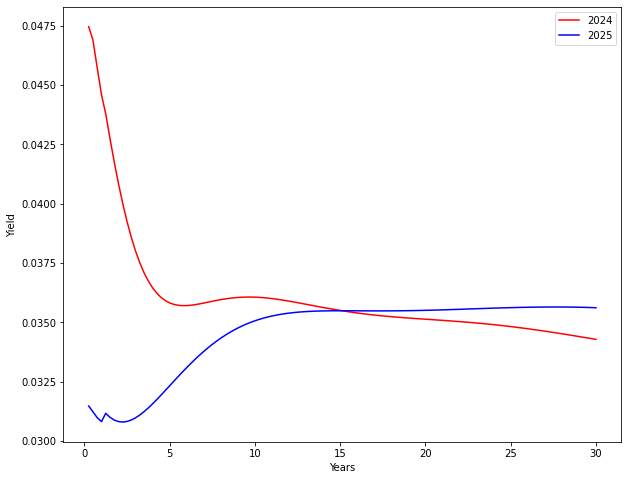

In [36]:
# plot the yield curve
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')
plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')

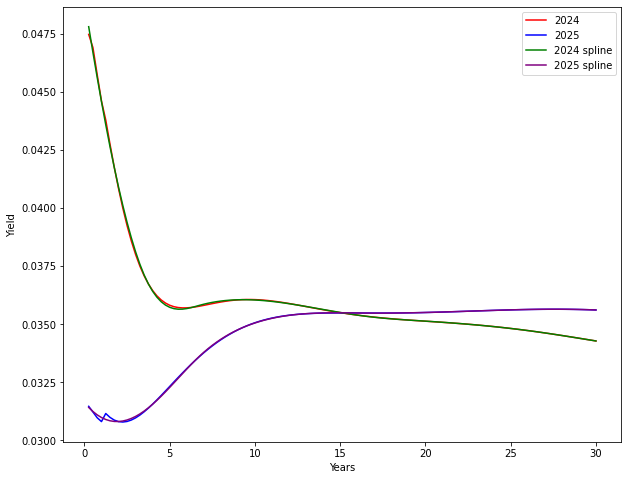

In [37]:
######### make model for splines to inteporlate the yield curve #########

# Define the positions of the knots (excluding the endpoints)
knots = np.linspace(yield_curve['Date'].min(), yield_curve['Date'].max(), 10)[1:-1]

# make the spline with specified knots
spline_2024 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2024_data'], t=knots, k=3)
spline_2025 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2025_data'], t=knots, k=3)

# make the plot
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')

plt.plot(yield_curve['Date'], spline_2024(yield_curve['Date']), label='2024 spline', color='green')
plt.plot(yield_curve['Date'], spline_2025(yield_curve['Date']), label='2025 spline', color='purple')

plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')
plt.show()

In [44]:
# given a date and a list of cash flow dates, find the number of years to the next cash flow date
def years_to_next_date(date, cash_flow_dates):

    days_to_next = [(cash_flow_date - date).days for cash_flow_date in cash_flow_dates if cash_flow_date > date]

    return min(days_to_next)/365

# fuction that given a start date, end date and frequency returns a list of dates that are the cash flow dates
def cashflow_dates(start_date, end_date, frequency):
    dates = []
    current_date = start_date

    while current_date > end_date:
        dates.append(current_date.date())
        current_date -= relativedelta(months=12/frequency)

    return dates


# given a bond with its maturity date, coupon frequency, issue date and interest rate and principal amount make a df of all the cash flows and the number of years away each one is
def cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate):

    # generate cashflow dates
    cash_flow_dates = cashflow_dates(maturity_date, offering_date, frequency)
    
    # remove all cash flows that are before today
    cash_flow_dates = [date for date in cash_flow_dates if date > today]

    # find the years to the next coupon date
    years_to_next_coupon = years_to_next_date(today, cash_flow_dates)

    # get the years to maturity of each cash flow, the first one is the number of days from today until the next coupon then each coupon is 12/frequency more
    years = np.arange(len(cash_flow_dates) - 1, -1, -1) * 1/frequency + years_to_next_coupon

    # combine cash flow dates and years into a df
    cash_flows = pd.DataFrame({'Date': cash_flow_dates, 'Years': years})

    # add cashflow amounts
    cash_flows['Amount'] = principal * interest_rate/frequency

    # add the principal to the last cashflow
    cash_flows.loc[cash_flows.index[0], 'Amount'] += principal

    return cash_flows

# a function that given the cashflows and the spline model of the yields discounts each one to the present value
def present_value(cash_flows, spline, spread=0):

    cash_flows['Discounted'] = cash_flows['Amount']/((1 + spline(cash_flows['Years']) + spread)**cash_flows['Years'])

    return sum(cash_flows['Discounted'])

# make a function that combines everything
def bond_value(offering_date, maturity_date, frequency, today, principal, interest_rate, spline, spread):

    cashflows = cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate)
    
    return present_value(cashflows, spline, spread)

# set day to 2024-05
date_2024 = datetime(2024, 5, 31).date()

# apply the bond_value function to the bonds df
bonds['2024_value'] = bonds.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2024, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2024, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

bonds['years_to_maturity'] = bonds.apply(lambda x : cashflows_and_years(x['OFFERING_DATE'],
                                                                       x['MATURITY'],
                                                                       x['INTEREST_FREQUENCY'],
                                                                       date_2024,
                                                                       x['PRINCIPAL_AMT'],
                                                                       x['COUPON']/100)['Years'][0], axis=1)

# the total price of all the bonds in the canadian market
bonds['2024_value'].sum()

9739715.52458329

In [15]:
# the total price of all the bonds in the USA market
bonds['raw_reported_price'] = bonds['RPTD_LAST_PR'] * bonds['PRINCIPAL_AMT'] /100
bonds['raw_reported_price'].sum()


9417960.74751

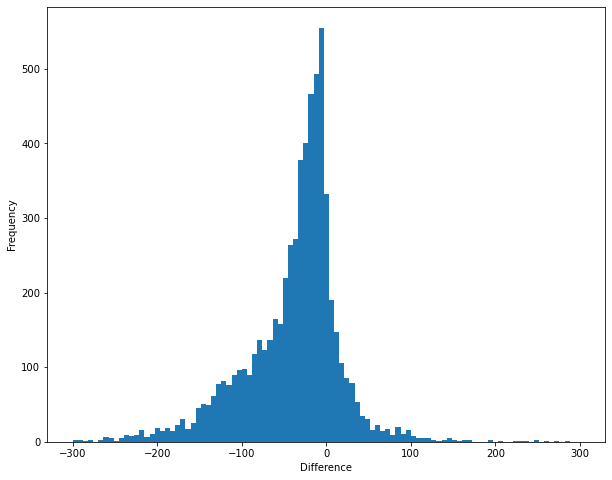

In [16]:
# take the difference between the usa prices and the canadian prices
bonds['difference'] = bonds['raw_reported_price'] - bonds['2024_value']

# histogram the differences only for a certain range
plt.figure(figsize=(10, 8)) 

plt.hist(bonds['difference'], bins=np.linspace(-300, 300, 100))

plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [46]:
# 2025 bond prices

# set day to jan 13, 2025
date_2025 = datetime(2025, 1, 13).date()

# remove the bonds that have already matured
bonds_2025 = bonds[bonds['MATURITY'] > datetime(2025,1,13)].copy()

# apply the bond_value function to the bonds df
bonds_2025['2025_value'] = bonds_2025.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2025, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2025, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

bonds_2025['years_to_maturity'] = bonds_2025.apply(lambda x : cashflows_and_years(x['OFFERING_DATE'],
                                                                       x['MATURITY'],
                                                                       x['INTEREST_FREQUENCY'],
                                                                       date_2025,
                                                                       x['PRINCIPAL_AMT'],
                                                                       x['COUPON']/100)['Years'][0], axis=1)


# sum of all the bond values
bonds_2025['2025_value'].sum()

9506016.551182697

In [47]:
bonds_2025.head()

,ISSUE_ID,TRD_EXCTN_DT,RPTD_LAST_PR,MATURITY,TREASURY_SPREAD,OFFERING_DATE,PRINCIPAL_AMT,INTEREST_FREQUENCY,COUPON,RATING,SECURITY_LEVEL,2024_value,years_to_maturity,2025_value
0,2560,2024-05-31,114.375,2031-09-15,80.0,1991-09-10,1000,2,8.750,BBB,SEN,1288.882531,6.667123,1299.344489
1,2562,2024-05-31,113.800,2031-11-15,85.0,1991-11-08,1000,2,8.625,BBB,SEN,1268.053609,6.834247,1278.997241
3,2564,2024-05-31,114.080,2043-04-15,100.0,1993-04-06,1000,2,7.875,BBB,SEN,1435.084790,18.252055,1443.434116
4,2566,2024-05-31,100.915,2025-06-15,69.0,1993-06-29,1000,2,7.250,BBB,SEN,1055.062910,0.419178,1020.093768
5,3857,2024-05-31,107.528,2029-10-15,8.0,1989-10-17,1000,2,8.000,BBB,SEN,1220.277010,4.752055,1227.372563


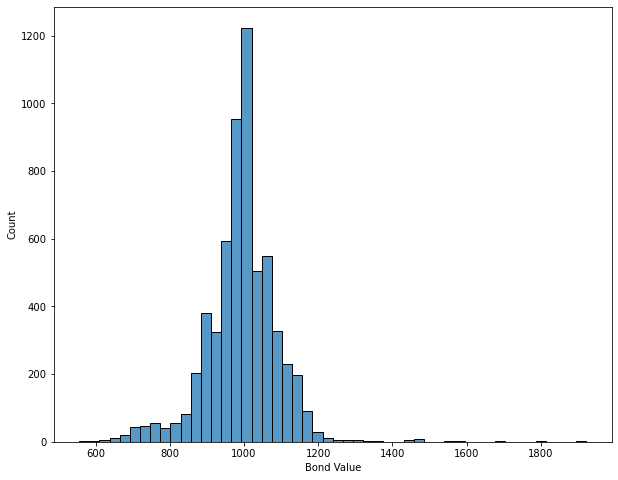

In [18]:
# make a distribution of the bond values for the bonds less than 100 000
plt.figure(figsize=(10, 8))

sns.histplot(bonds_2025[bonds_2025['2025_value'] < 2000]['2025_value'], bins=50)

plt.xlabel('Bond Value')

plt.show()